In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import os
#import imageio.v2 as imageio
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import keras
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout 
from keras.layers import Conv2DTranspose
from keras.layers import concatenate
from termcolor import colored

from glob import glob
from scipy.io import loadmat
from tensorflow.keras import layers

In [2]:
image_path = 'C:/Users/leekh/Desktop/drone/dataset/semantic_drone_dataset/original_images/'
mask_path = 'C:/Users/leekh/Desktop/drone/dataset/semantic_drone_dataset/label_images_semantic/'

IMAGE_SIZE = 256 
NUM_CLASSES = 23

In [3]:
image_list = os.listdir(image_path)
im_list = image_list
mask_list = os.listdir(mask_path)

In [4]:
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in im_list]

for x in range(0,400):
    mask_list[x] = mask_list[x][:-4] + '.png'

Text(0.5, 1.0, 'Segmentation')

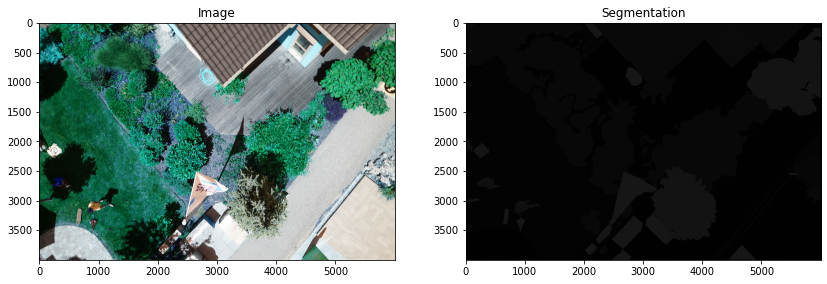

In [5]:
N = 56
img = cv2.imread(image_list[N])
mask = cv2.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Segmentation')

In [6]:
import tensorflow as tf
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'C:\\Users\\leekh\\Desktop\\drone\\dataset\\semantic_drone_dataset\\original_images\\000.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'C:\\Users\\leekh\\Desktop\\drone\\dataset\\semantic_drone_dataset\\label_images_semantic\\000.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'C:\\Users\\leekh\\Desktop\\drone\\dataset\\semantic_drone_dataset\\original_images\\001.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'C:\\Users\\leekh\\Desktop\\drone\\dataset\\semantic_drone_dataset\\label_images_semantic\\001.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'C:\\Users\\leekh\\Desktop\\drone\\dataset\\semantic_drone_dataset\\original_images\\002.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'C:\\Users\\leekh\\Desktop\\drone\\dataset\\semantic_drone_dataset\\label_images_semantic\\002.png'>)


In [7]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'C:/Users/leekh/Desktop/drone/dataset/semantic_drone_dataset/original_images/000.jpg', shape=(), dtype=string)
tf.Tensor(b'C:/Users/leekh/Desktop/drone/dataset/semantic_drone_dataset/label_images_semantic/000.png', shape=(), dtype=string)


In [8]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (256, 256), method='nearest')
    input_mask = tf.image.resize(mask, (256, 256), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [10]:
def convolution_block(
    block_input,
    num_filters=128,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [11]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [12]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(4000, 6000, 1)


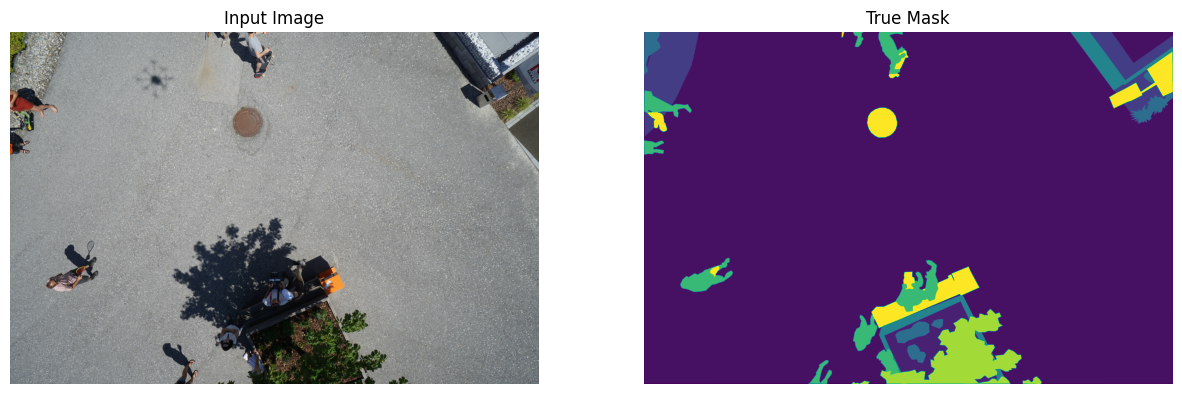

In [13]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(256, 256, 1)


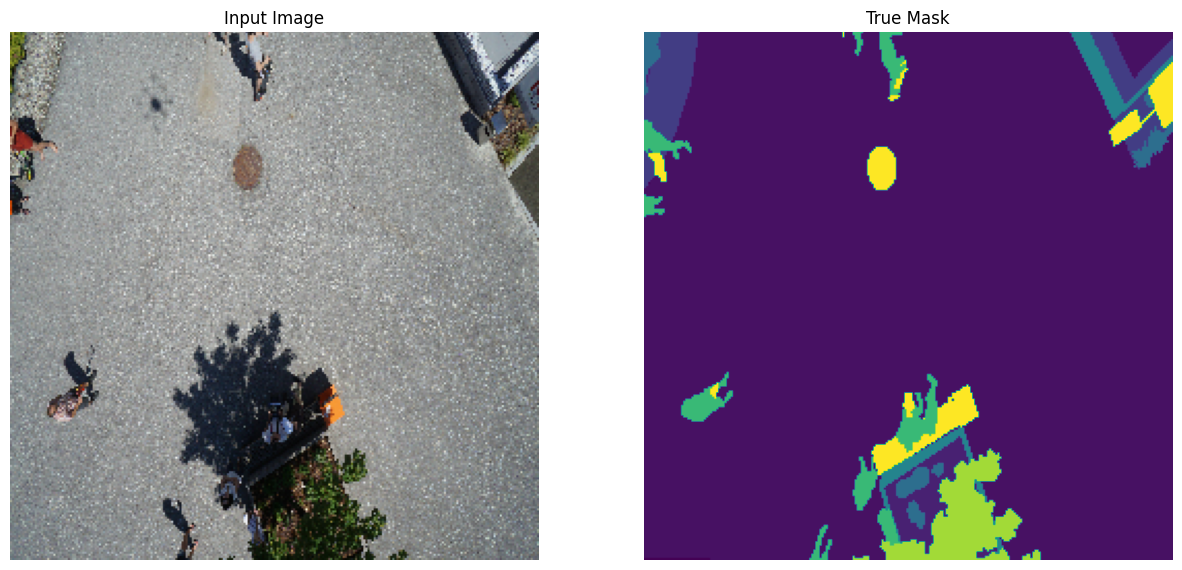

In [14]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [12]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [9]:
EPOCHS = 350
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 8

processed_image_ds=processed_image_ds.shuffle(BUFFER_SIZE)

ts=len(processed_image_ds)
val_dataset=processed_image_ds.skip(int(ts*0.8))
train_dataset=processed_image_ds.take(int(ts*0.8))

print(len(val_dataset))
print(len(train_dataset))

val_dataset.batch(BATCH_SIZE)
train_dataset.batch(BATCH_SIZE)

train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print(len(val_dataset))
print(len(train_dataset))
print(processed_image_ds.element_spec)

80
320
10
40
(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))


In [17]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights = True)

In [18]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, batch_size=8, callbacks=[es])

Epoch 1/350
40/40 [==============================] - 88s 1s/step - loss: 1.6206 - accuracy: 0.5615 - val_loss: 1055.2048 - val_accuracy: 0.2380
Epoch 2/350
40/40 [==============================] - 7s 168ms/step - loss: 1.0851 - accuracy: 0.6869 - val_loss: 8.8377 - val_accuracy: 0.0334
Epoch 3/350
40/40 [==============================] - 7s 168ms/step - loss: 0.8893 - accuracy: 0.7307 - val_loss: 4.0754 - val_accuracy: 0.0572
Epoch 4/350
40/40 [==============================] - 7s 166ms/step - loss: 0.8141 - accuracy: 0.7476 - val_loss: 6.9701 - val_accuracy: 0.0383
Epoch 5/350
40/40 [==============================] - 7s 168ms/step - loss: 0.7067 - accuracy: 0.7806 - val_loss: 5.6671 - val_accuracy: 0.0355
Epoch 6/350
40/40 [==============================] - 7s 168ms/step - loss: 0.6228 - accuracy: 0.8026 - val_loss: 5.8240 - val_accuracy: 0.0568
Epoch 7/350
40/40 [==============================] - 7s 170ms/step - loss: 0.6058 - accuracy: 0.8092 - val_loss: 3.9306 - val_accuracy: 0.371

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

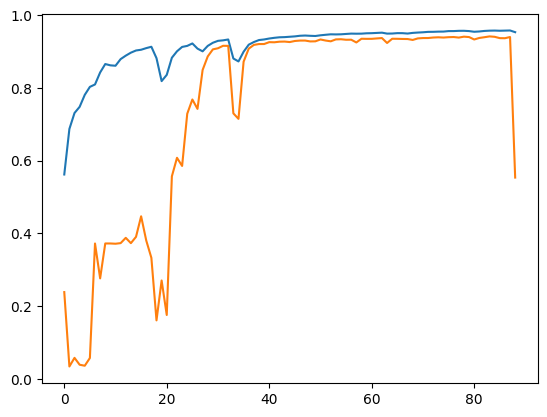

In [31]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

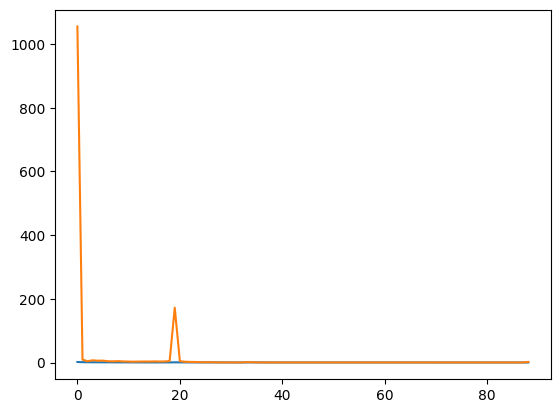

In [32]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [33]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [12]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

1/1 [==============================] - 0s 61ms/step


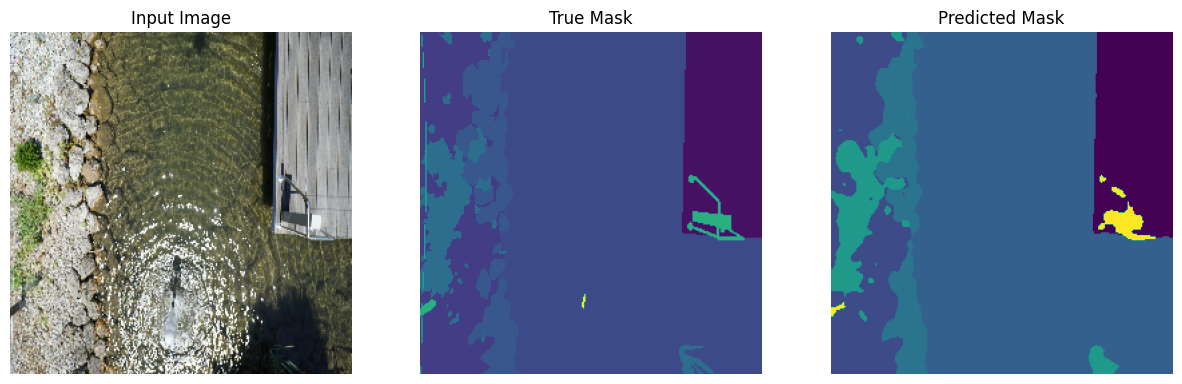

In [35]:
for image, mask in val_dataset.take(1):
    pred_mask = model.predict(image)
    display([image[0], mask[0], create_mask(pred_mask)])

In [36]:
# save model as h5 file
model.save('deeplabv3plus.h5')

In [10]:
deeplab_loaded = keras.models.load_model('deeplabv3plus.h5')

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay, roc_curve
from keras.metrics import MeanIoU
from keras.utils import to_categorical
from keras import backend as K
import statistics
import seaborn as sns

def evaluateMask(true_mask, predicted_mask): 
    # Flatten the masks to 1D arrays
    true_mask = to_categorical(true_mask.numpy().flatten(), num_classes=23)
    predicted_mask = to_categorical(predicted_mask.numpy().flatten(), num_classes=23)
    
    # Mean Iou Score
    mean_iou = MeanIoU(num_classes=23)
    mean_iou.update_state(true_mask, predicted_mask)
    iou_score = mean_iou.result().numpy()
    
    # Confusion matrix
    cm = confusion_matrix(np.argmax(true_mask, axis=1), np.argmax(predicted_mask, axis=1), labels=range(23))
    
    # Calculate the metrics
    tp = np.diag(cm)
    fp = np.sum(cm, axis=0) - tp
    fn = np.sum(cm, axis=1) - tp
    tn = np.sum(cm) - (tp + fp + fn)

    sns.heatmap(cm, annot=True)

    precision = tp / (tp + fp)
    precision_mean = np.mean(np.nan_to_num(precision))
    recall = tp / (tp + fn)
    recall_mean = np.mean(np.nan_to_num(recall))
    accuracy = np.sum(tp) / np.sum(cm)
    f1_score = 2 * precision * recall / (precision + recall)
    f1_score_mean = np.mean(np.nan_to_num(f1_score))
    dice_coefficient = (2 * tp) / (2 * tp + fp + fn)
    dice_coefficient_mean = np.mean(np.nan_to_num(dice_coefficient))
    
    # Print the results
    print("Classification Report:\n", classification_report(np.argmax(true_mask, axis=1), np.argmax(predicted_mask, axis=1)))
    print("Mean IoU score:", iou_score)
    print("Recall:", recall_mean)
    print("Precision:", precision_mean)
    print("Accuracy:", accuracy)
    print("F1 score:", f1_score_mean)
    print("Dice coefficient:", dice_coefficient_mean)

    # Plot the confusion matrix
    sns.heatmap(cm, xticklabels=['P0', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7'
                                 , 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14'
                                 , 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 
                                 'P21', 'P22'], 
                yticklabels=['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7'
                            , 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15'
                            , 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22'],
    annot=True, fmt='d', annot_kws={'fontsize':6}, cmap="YlGnBu")

1/1 [==============================] - 3s 3s/step


c:\Users\leekh\anaconda3\envs\open-cv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leekh\anaconda3\envs\open-cv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leekh\anaconda3\envs\open-cv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.01      0.03       722
           1       0.98      0.97      0.98     21111
           2       0.80      0.86      0.83      1493
           3       0.95      0.97      0.96      6844
           4       0.95      0.94      0.94     11523
           6       0.90      0.62      0.74       192
           8       0.95      0.90      0.92      5174
           9       0.97      0.99      0.98      8992
          10       0.74      0.96      0.84      2693
          11       0.91      0.87      0.89       202
          13       0.87      0.89      0.88       856
          14       0.00      0.00      0.00        58
          15       0.62      0.83      0.71       378
          17       0.83      0.85      0.84       128
          19       0.94      0.97      0.95      3501
          22       0.88      0.71      0.79      1669

    accuracy                           0.94     65536
  

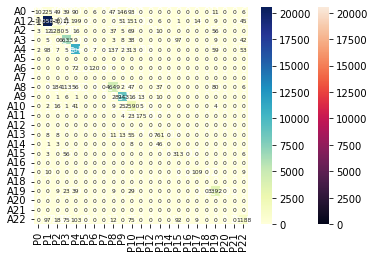

In [13]:
for image, mask in val_dataset.take(1):
    output = deeplab_loaded.predict(image)

np.seterr(divide='ignore', invalid='ignore')
evaluateMask(mask[0], create_mask(output))